# Goals

In this file, I want to take the sliced arrays of data from the "CuttingData.ipynb" file and assign membership Booleans and overdensity values to each galaxy in my data cube.

For this, I need:
- List of galaxies with an (RA, dec, z)
- VMC map for overdensities
- .dat files from "find_peaks.py" that has galaxy memberships

Then, I can write a python function that takes in the parameters above and spits out:
- the overdensity value of a given galaxy
- if the galaxy is a member for a given overdensity

In [1]:
### IMPORTS ###
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from astropy.cosmology import Planck15, FlatLambdaCDM
from astropy import units as u

### COSMOLOGY ###
cosmo = FlatLambdaCDM(H0=70.0, Om0=0.27)

In [2]:
### IMPORT GALAXY DATA ###

## C20 phot data:
c20p = np.load("Data/Hyperion_C20_phot_noOD.npy", allow_pickle=True)

## C20 spec data:
c20s = np.loadtxt("Data/Hyperion_C20_spec_noOD.txt", dtype=str, skiprows=1)

# Fix up the formatting for the spec data-file:
new_array = []
for idx in range(c20s.shape[1]):
    try:
        col = c20s[:,idx].astype(np.float32)
    except:
        col = c20s[:,idx]
    new_array.append(col)

c20s = np.array(new_array, dtype=object)
c20s = np.transpose(c20s)

In [3]:
### IMPORT OD DATA ###

## VMC map
vmc = fits.open(r"C:/Users/sikor/OneDrive/Desktop/BigData/HyperionVMC/" + \
                "masterallz.COSMOS.mastermedVoronoi.specprobabilistic.overdens.100interations.fits")

## Interpolated sigma cube
sig_cube = fits.open(r"C:\Users\sikor\OneDrive\Desktop\benpy\ThirdTry\Hyperion_interpolated_cube_sigma.fits")

## Path for folders with .dat sigma files
sigPath = r"C:\Users\sikor\OneDrive\Desktop\benpy\HyperionPeaks"

### Sigma-file Data description

0. Smoothed grid of the interpolated densities for each redshift (RA, dec, z)
1. 1D array of RA
2. 1D array of Dec
3. 1D array of avg z for each slice
4. 1D array of min z for each slice
5. 1D array of max z for each slice
6. mean density as fn of z
7. mean overdensity as fn of z
8. std dev of overdensity as fn of z
9. 2nd-order poly fit of (7)
10. 2nd-order poly fit of (8)
11. 5th-order poly fit of (7)
12. 5th-order poly fit of (8)

where "overdensity" $\log(1+\delta_{gal})$ is given by:
$$
\log(1+\delta_{gal}) = \frac{\Sigma}{\bar{\Sigma}}
$$

---
---
---

# Memberships and Overdensities

In [4]:
def getMembers(gal_data, sig_cube, sig_path, sig_sums, sig_folders, write=False):
    """
    For each sigma, get membership status of galaxies

    INPUTS:
        
    """

    ## Get Voxel each gal is in, it's overdensity, and sigma above mean (at given z)
    voxels = []
    ods = []
    n_sig = []
    for g in gal_data:
        # Find voxel for [RA, dec, z_mean] of each galaxy 
        v = [np.argmin(np.abs(sig_cube[1].data - g[0])),
             np.argmin(np.abs(sig_cube[2].data - g[1])),
             np.argmin(np.abs(sig_cube[3].data - g[2]))] 
        voxels.append(v)    # Add the 3d voxel coord for the galaxy
        
        # Find overdensity (log(1+del_gal)
        od = np.log10(sig_cube[0].data[v[2],v[1],v[0]] / sig_cube[6].data[v[2]] )
        ods.append(od)  

        # Find sigma above mean for given z-slice
        n = (od - sig_cube[11].data[v[2]]) / sig_cube[12].data[v[2]]    # (od - mean) / sigma
        n_sig.append(n)

    if write==True:
        save_array = np.c_[np.arange(len(voxels)), voxels, n_sig]
        np.savetxt("VoxelTest.txt", save_array.astype(int), fmt="%10.3i")


    ## For each sigma, test membership and return peak number
    member_info = []    # Fill up for each sigma

    for idx, s in enumerate(sig_sums):

        pk_numbers = []    # What I'm storing the results in for this sigma

        ## Find which peak (if any) contains the galaxy voxels
        pk_sum = np.genfromtxt(sig_path + s, dtype=float, skip_header=0)      # Peak summary info
        
        pk_dict = {}        # Fill dict with peak info so I don't have to load in multiple times

        for v in voxels:    # loop over each gal

            v_status = False     # Remember if a galaxy has had a match found

            for p in pk_sum:    # test each peak til I find appropriate range

                if (p[-6]<=v[0] <= p[-5]) and (p[-4]<=v[1]<=p[-3]) and (p[-2]<=v[2]<=p[-1]):
                    # If the voxel is potentially in the peak, find info if true
                    
                    try:
                        p_data = pk_dict[p[0]]  # If I've already read in the peak data, just use that
                    except:
                        try:
                            p_data = np.genfromtxt(sig_path+sig_folders[idx]+"\\"+f"pixels_{int(p[0])}.dat", comments = '#')
                        except:
                            p_data = np.genfromtxt(sig_path+sig_folders[idx]+"\\"+f"pixels_0{int(p[0])}.dat", comments = '#')
                        # If peak hasn't been looked at yet, then save it to the dictionary. Note the name is weird because first peak is "peak 1"
                        pk_dict[p[0]] = p_data  # Add to dictionary

                    # Find if the galaxy voxel appears in this peak
                    good_voxels = np.where((p_data[:,0] == v[0]) & (p_data[:,1]==v[1]) & (p_data[:,2] == v[2]))[0]

                    if (len(good_voxels) != 0) and (v_status == False):
                        # Match found! Save the peak number for this galaxy and pass to next one
                        pk_numbers.append(p[0])
                        v_status = True
                        pass
                    
            if v_status == False:
                pk_numbers.append(-99)  # If after loop over summary file potential match is found, then add -99 to file for peak number
            
        
        # Add to membership info, or define info if this is the first sigma
        if idx == 0:
            member_info = pk_numbers
        else:
            member_info = np.c_[member_info, pk_numbers]


    return ods, n_sig, member_info


In [5]:
### MEMBERSHIP FOR SPECs ###
gal_locations = np.c_[c20s[:,4], c20s[:,6], c20s[:,11]]
sigs = [5.0, 4.5, 4.0, 3.5, 3.0, 2.5, 2.0]
sig_path = sigPath
sig_sums = [f"\peaks_sig{s}.dat" for s in sigs]
sig_folders = [f"\sig{s}_peaks" for s in sigs]

ods, n_sigs, spec_membership = getMembers(gal_locations, sig_cube, sig_path, sig_sums, sig_folders)

c20s_od = np.c_[c20s, ods]
c20s_odn = np.c_[c20s_od, n_sigs]
c20s_od_mems = np.c_[c20s_odn, spec_membership]

In [6]:
### MEMBERSHIP FOR PHOTOs ###
gal_locations = np.c_[c20p["ALPHA_J2000"], c20p["DELTA_J2000"], c20p["lp_zPDF"]]
sigs = [5.0, 4.5, 4.0, 3.5, 3.0, 2.5, 2.0]
sig_path = sigPath
sig_sums = [f"\peaks_sig{s}.dat" for s in sigs]
sig_folders = [f"\sig{s}_peaks" for s in sigs]

ods, n_sig, phot_membership = getMembers(gal_locations, sig_cube, sig_path, sig_sums, sig_folders, write=True)

### Append the peak info to the c20p array ###
old_ds = c20p.dtype.descr    # Old dtypes
more_ds = [("OD", ">f8"), ("n_sigma", ">f8")] +[(f"sigma_{s}", ">f8") for s in sigs]     # Add new dtypes for overdensity and each sigma
new_ds = np.dtype(old_ds + more_ds)     # Append the new dtypes 

c20p_od_mems = np.zeros(c20p.shape, dtype=new_ds)    # generate an array of zeros to fill

# Fill up the array

for d in old_ds:    # Refill everything that was in original file
    c20p_od_mems[d[0]] = c20p[d[0]]

for idx, head in enumerate(more_ds):    # Fill all of the new columns
    if idx == 0: 
        c20p_od_mems[head[0]] = ods
    elif idx == 1:
        c20p_od_mems[head[0]] = n_sig
    else:
        c20p_od_mems[head[0]] = phot_membership[:,idx-2]

---
---
---

# Save Data

In [10]:
### Save spec ###
heads = [["ID_C20", "ID_spec", "Survey", "RA_spec", "RA_C20", "Dec_spec", "Dec_C20", "K_C20", "K_diff",
         "i_C20", "i_diff", "z_spec", "z_C20", "Spec_QF", "Match_Flag", "M_med", "M_16", "M_84",
          "SFR_med", "SFR_16", "SFR_84", "Age_med", "Age_16", "Age_84", "NUV_abs", "u_abs", "r_abs",
           "V_abs", "J_abs", "chi-sqr_Lehare", "Model_idx_Lephare", "E(B-V)_Lephare", "Overdensity_VMC", "n_sigma",
            "sigma_5.0", "sigma_4.5", "sigma_4.0", "sigma_3.5", "sigma_3.0", "sigma_2.5", "sigma_2.0" ]]
c20s_save = np.concatenate([heads,c20s_od_mems])
fmts = []
for col in range(c20s_save.shape[1]):
    col_data = c20s_save[:,col].astype(str)  #make all elements strings to check length
    m_length = max([len(d) for d in col_data])  # find max length of elements in array
    fmts.append(f'%-{int(m_length+4)}s')

np.savetxt("Data/Hyperion_C20_spec.txt", c20s_save, fmt=fmts)

In [11]:
### Save Photometric data ###
np.save("Data/Hyperion_C20_phot.npy", c20p_od_mems)

---
---
---


# Re-find peak volumes

I want to calculate a new peak-volume using astropy and then add this to the peak data-files.

In [12]:
def AP_coVol(ra, dec, zs):
    """
    Return a comoving volume using Astropy in Mpc^3
    """
    theta_dec = np.abs(dec[1]-dec[0])*np.pi/180 * u.rad
    theta_RA  = np.abs(ra[0]-ra[1])*np.pi/180 * u.rad * np.cos(theta_dec)
    Omega     = (theta_RA * theta_dec).to(u.steradian).value # get rid of unit

    V         = Omega/(4*np.pi) *(cosmo.comoving_volume(zs[1]) - cosmo.comoving_volume(zs[0]))

    return V.value

In [13]:
def newVol(zs, z_map):
    """
    Given a list of voxel-numbers (zs) and a dictionary that maps voxel-number to volume, this returns the sum of the volume of voxels
    """
    return sum([z_map[z] for z in zs]) /10

In [14]:
### Make a map of voxel-to-volume

z_map = {}  # Fill with z_vox : vol 
dec_idx = int(len(sig_cube[2].data) / 2)    # Find the average dec in the cube to adjust the delta_ra
ra_vals = [sig_cube[1].data[0], sig_cube[1].data[1]]
dec_vals = [sig_cube[2].data[dec_idx], sig_cube[2].data[dec_idx+1]]


# Loop through average redshift values to find volume for a given redshift index
for id, z in enumerate(sig_cube[3].data):
    z_vals = [sig_cube[4].data[id], sig_cube[5].data[id]]

    z_map[id] = AP_coVol(ra_vals, dec_vals, z_vals)

In [15]:
sum(list(z_map.values()))*len(sig_cube[1].data)*len(sig_cube[2].data) /10

17568201.120089788

In [16]:
### Find volume for each peak and write to file ###

save_path = "HyperionPeaks_new/"     # Folder to save stuff to
old_path = "HyperionPeaks/"


sigs = np.arange(5.0, 1.5, -.5)

for s in sigs:

    sig_sum = np.genfromtxt(old_path+ f"peaks_sig{s}.dat")

    pk_dir = old_path + f"sig{s}_peaks/"

    New_Vols = []      # Fill with the new_volumes

    for idx in sig_sum[:,0]:
        
        try:
            voxels = np.genfromtxt(pk_dir+f"pixels_{int(idx)}.dat", comments = '#')
        except:
            voxels = np.genfromtxt(pk_dir+f"pixels_0{int(idx)}.dat", comments = '#')

        New_Vols.append(newVol(voxels[:,2], z_map))


    new_sum = np.c_[sig_sum, New_Vols]

    vol_diff = new_sum[:,-1] / new_sum[:,10]
    new_sum = np.c_[new_sum, vol_diff]

    np.savetxt(save_path +  f"peaks_sig{s}.dat", new_sum, fmt="%10.6g")

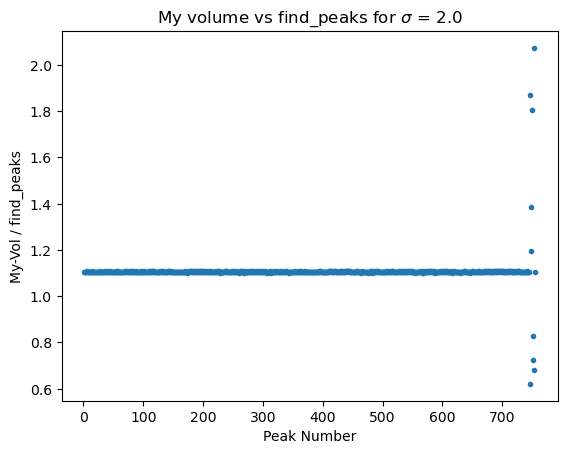

In [17]:
sigs = np.arange(5.0, 1.5, -.5)

for s in sigs:

    sig_sum = np.genfromtxt(save_path+ f"peaks_sig{s}.dat")
    
    plt.clf()
    plt.plot(sig_sum[:,0], sig_sum[:,-1], '.')
    plt.xlabel("Peak Number")
    plt.ylabel("My-Vol / find_peaks")
    plt.title(rf"My volume vs find_peaks for $\sigma$ = {s}")
    plt.savefig(f"test_{s}.png")